In [87]:
import os
import sys
import random
from datetime import datetime


sys.path.append('../src')

from design_gene_blocks import DesignEblocks
from design_IVA_primers import DesignPrimers
from snapgene_output import SnapGeneOutput

# !pip3 install openpyxl

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
# TODO Add image of the vector

# https://www.biotite-python.org/examples/gallery/sequence/plasmid_map_custom.html

In this tutorial we will randomly design a number of mutations for the replicative DNA polymerase DnaE1 from *Mycobacterium smegmatis* to better understand it's function. <br>

The expression plasmid containing Msmeg DnaE1 is XXX and is stored in XXX. <br>

Gene from mycobrowser XXX and is stored in XXX <br>

In [89]:
# File locations for input and output

vector = 'files/snapgene_vector.dna' # TODO Change name and change vector (see snapgene computer which one to take)
msmeg_dnae1 = 'files/A0QX55.fasta'  # M. smegmatis DnaE1 gene
gene_name = "Msmeg DnaE1"
output_location = 'output/'  # Location to store the files created in this notebook
codon_usage = 'Mycobacterium Smegmatis' # We want to use the codon usage of this organism
codon_usage_fp = r"C:\Users\Rosan\Documents\git\my_repositories\design_gene_blocks\src\data\codon_usage" # Location of the codon usage files
optimize = 'cost'

First we open the nucleotide sequence of Msmeg DnaE1 and translate this to the protein sequence. Here, the start and stop codon are not translated 

In [90]:
# Load the nucleotide sequence

msmeg_dnae1_dna = DesignEblocks.read_seq(msmeg_dnae1)
print("Nucleotide sequence: ", msmeg_dnae1_dna)

# Translate nucleotide to protein sequence

msmeg_dnae1_protein = msmeg_dnae1_dna.translate()
print("Protein sequence: ", msmeg_dnae1_protein)

# Create a list of all DnaE1 residues

msmeg_dnae1_residues = [i + str(j) for i, j in zip(msmeg_dnae1_protein, range(1, len(msmeg_dnae1_protein) + 1))]
print("Residues: ", msmeg_dnae1_residues)

Nucleotide sequence:  atgagcggttcatctgcggggtcctccttcgtgcacctgcacaaccacaccgagtattcgatgctggacggtgccgcgaagatcacgcccatgctcgccgaggtggagcggctggggatgcccgcggtggggatgaccgaccacggaaacatgttcggtgccagcgagttctacaactccgcgaccaaggccgggatcaagccgatcatcggcgtggaggcatacatcgcgccgggctcgcggttcgacacccggcgcatcctgtggggtgaccccagccaaaaggccgacgacgtctccggcagcggctcctacacgcacctgacgatgatggccgagaacgccaccggtctgcgcaacctgttcaagctgtcctcgcatgcttccttcgagggccagctgagcaagtggtcgcgcatggacgccgagctcatcgccgaacacgccgagggcatcatcatcaccaccggatgcccgtcgggggaggtgcagacccgcctgcggctcggccaggatcgggaggcgctcgaagccgcggcgaagtggcgggagatcgtcggaccggacaactacttccttgagctgatggaccacgggctgaccatcgaacgccgggtccgtgacggtctgctcgagatcggacgcgcgctcaacattccgcctcttgccaccaatgactgccactacgtgacccgcgacgccgcccacaaccatgaggctttgttgtgtgtgcagaccggcaagaccctctcggatccgaatcgcttcaagttcgacggtgacggctactacctgaagtcggccgccgagatgcgccagatctgggacgacgaagtgccgggcgcgtgtgactccaccttgttgatcgccgaacgggtgcagtcctacgccgacgtgtggacaccgcgcgaccggatgcccgtgtttccggtgcccgatgggcatgaccaggcgtcctggctgcgtcacgaggtggac

Now we will randomly design some mutations for this gene. Here, we will not generate any mutations in the N- or C- terminal region, to ensure we can create a 20bp overlap with the beginning or end of the gene in our eBlock design <br>

1. **Single point mutations** <br>

Single point mutations contain a single mutation per eBlock

2. **Multiple point mutations in same eBlock**

Multiple point mutations contain multiple mutations in the same eBlock

3. **Inserts**

Inserts contain addition of amino acids in the eBlock

4. **Deletions**

Deletions have parts of the gene deleted

In [91]:
# List containing all natural amino acids and options for our mutations
amino_acids = ['A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'S', 'T', 'N', 'Q', 'C', 'G', 'P', 'R', 'H', 'K', 'D', 'E']

# Set of functions to randomly select mutations and insertions/deletions

def random_single_mutation(residues, aas, n):
    """
    Randomly select single mutations in a protein sequence.

    Parameters
    ----------
    residues : list
        List of residues in the protein sequence
    choices : list
        List of all natural amino acids
    n : int
        Number of mutations to sample
    """
    res = random.sample(residues, n)
    mut = random.choices(aas, k=n)
    mutants = [i + j for i, j in zip(res, mut)]
    return mutants

def random_multiple_mutation(residues, aas, n, max_distance_between_mutants=50, max_number_mutations=5):
    """
    Randomly select multiple mutations in a protein sequence that will be combined in one mutant.

    Parameters
    ----------
    residues : list
        List of residues in the protein sequence
    aas : list
        List of all natural amino acids
    n : int
        Number of mutations to sample
    max_distance_between_mutants : int
        Maximum distance (in residues) between the two mutations, default is set to 10
    """
    mutants = []  # List to store the mutants
    region_to_be_sampled = residues[(max_distance_between_mutants + 1):-max_distance_between_mutants]
    res1 = random.sample(region_to_be_sampled, n)
    var1 = random.choices(aas, k=n) 
    mut1 = [i + j for i, j in zip(res1, var1)]
    for i in mut1:
        temp_muts = []
        num_mutations = random.sample(range(1, max_number_mutations), 1)[0]
        pos_x = random.sample(range(1, max_distance_between_mutants), num_mutations)
        vars_x = random.choices(aas, k=num_mutations)  # Corrected typo here
        for j, k in zip(pos_x, vars_x):
            index = residues.index(i[0:-1])
            mut_x = residues[index + j] + k
            temp_muts.append(mut_x)
        mutants.append(i + '-' + '-'.join(temp_muts))
    return mutants


def random_insert(residues, aas, n, max_length_insertion=10):
    """
    Randomly generate insertions in a protein sequence.

    Parameters
    ----------
    residues : list
        List of residues in the protein sequence
    choices : list
        List of all natural amino acids
    n : int
        Number of insertions to sample
    max_length_insertion : int 
        Maximum length of the insertion, default is set to 10
    """
    inserts = []  # List to store the inserts
    for i in range(n):
        len_insertion = random.sample(range(1, max_length_insertion), 1)[0]
        insertion = random.choices(aas, k=len_insertion)
        insertion = ''.join(insertion)
        residue = random.sample(residues, 1)[0]
        insert = residue + '-' + insertion
        inserts.append(insert)
    return inserts


def random_deletion(residues, n, max_length_deletion=10):
    """
    Randomly generate deletions in a protein sequence.

    Parameters
    ----------
    residues : list
        List of residues in the protein sequence
    n : int
        Number of deletions to sample
    max_length_deletion : int
        Maximum length of the deletion, default is set to 10
    """
    deletions = []
    for i in range(n):
        len_deletion = random.sample(range(1, max_length_deletion), 1)[0]
        res_b = random.sample(residues, 1)[0]
        res_e = residues[residues.index(res_b) + len_deletion]
        deletion = res_b + '-' + res_e
        deletions.append(deletion)
    return deletions

In [139]:
# Do not make the mutations at the very beginning and end of the protein sequence, because this will result in difficulties with the primers
usable_residues = msmeg_dnae1_residues[20:-20]

# Randomly select single mutations
number_single = 25
selected_single_mutants = random_single_mutation(usable_residues, amino_acids, number_single)
print(f"Generated {number_single} single mutations: ", selected_single_mutants)

# Randomly select double mutations
number_double = 30
selected_double_mutants = random_multiple_mutation(usable_residues, amino_acids, number_double)
print(f"Generated {number_double} paired mutations: ", selected_double_mutants)

# Randomly select insertions
number_insertions = 10
selected_insertions = random_insert(usable_residues, amino_acids, number_insertions)
print(f"Generated {number_insertions} insertions: ", selected_insertions)

# Randomly select deletions
number_deletions = 10
selected_deletions = random_deletion(usable_residues, number_deletions)
print(f"Generated {number_deletions} deletions: ", selected_deletions)

total_number_mutations = number_single + number_double + number_insertions + number_deletions
print(f"Total number of mutations: {total_number_mutations}")

Generated 25 single mutations:  ['A568K', 'K457T', 'R1090H', 'Q1048Y', 'R255G', 'E415N', 'S898K', 'A799D', 'V523W', 'G912I', 'A1113Y', 'K884T', 'L908M', 'A725Y', 'L222P', 'E657A', 'I402Q', 'A730F', 'P994L', 'L589P', 'A268P', 'N866S', 'D259P', 'F964S', 'K939E']
Generated 30 paired mutations:  ['M758R-F778I-T798G-N784W', 'I468Y-A476A', 'F1103N-C1121S-Q1120I', 'R429M-K459L', 'T155Q-L167G', 'Q638Q-R686A-G669P', 'N1096H-P1117E-L1112S-Q1141C-T1099T', 'A766S-T774I-N784I', 'P806N-K833H-A851V-N844Y', 'Y796G-A811W-R832E', 'L627Y-Q638F-M673N', 'V871S-C900Y-L875A-K910Q-I897Y', 'G187E-E194P-V230C', 'G642P-K683K', 'D933D-G958V-L936G-F950L', 'P78Y-T116Q-D98V', 'A661K-I663S', 'P559S-F588T-L591S', 'A461K-P487F-P495G-I499D-R506L', 'L287Q-D298D-S319W-W300I-V299T', 'F950D-A980Y-V990D-N953D-L981K', 'G336G-A365Q-S384R', 'K939P-D975W-F964K-G951L', 'T1053Y-F1061Q', 'P1011E-G1016V-L1052F-Q1023F', 'N218S-Y264G-V230E-R255E', 'G912N-A913R', 'A179G-N190F-I219S-E184L-T201F', 'V447C-L496I-T458D-S465C', 'Y360L-A371M'

In [140]:
# Formatting the mutations in a format that can be read by the DesignEblocks class, see documentation for more information about this

now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H:%M")
mutationsfile = f'files/mutations_random_Msmeg_DnaE1_N{total_number_mutations}_{dt_string}.txt'

with open(mutationsfile, 'w') as f:
    for i in selected_single_mutants:
        f.write(i + '\n')
    for i in selected_double_mutants:
        f.write('Combined ' + i + '\n')
    for i in selected_insertions:
        f.write('Insert ' + i + '\n')
    for i in selected_deletions:
        f.write('Deletion ' + i + '\n')

Now that we have selected the mutations that we want to create, we can start the design of the eBlocks. <br>
First, we create an instance of the DesignEblocks class and provide the information. Next we will start the design of the eBlocks. <br>
<br>

TODO: Describe the steps that are carried out in this class

In [141]:
# Create instance of DesignEblocks to design the eBlocks per mutation

eBlocks_instance = DesignEblocks(
                        sequence_fp=msmeg_dnae1,
                        gene_name=gene_name,
                        mutations_fp=mutationsfile,
                        optimize='cost', # Optimize for the cost of the eBlocks (default) 'cost', or for the number of eBlocks 'amount'
                        output_fp=output_location,
                        species=codon_usage,
                        codon_usage_fp=codon_usage_fp)

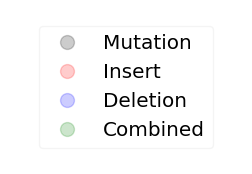

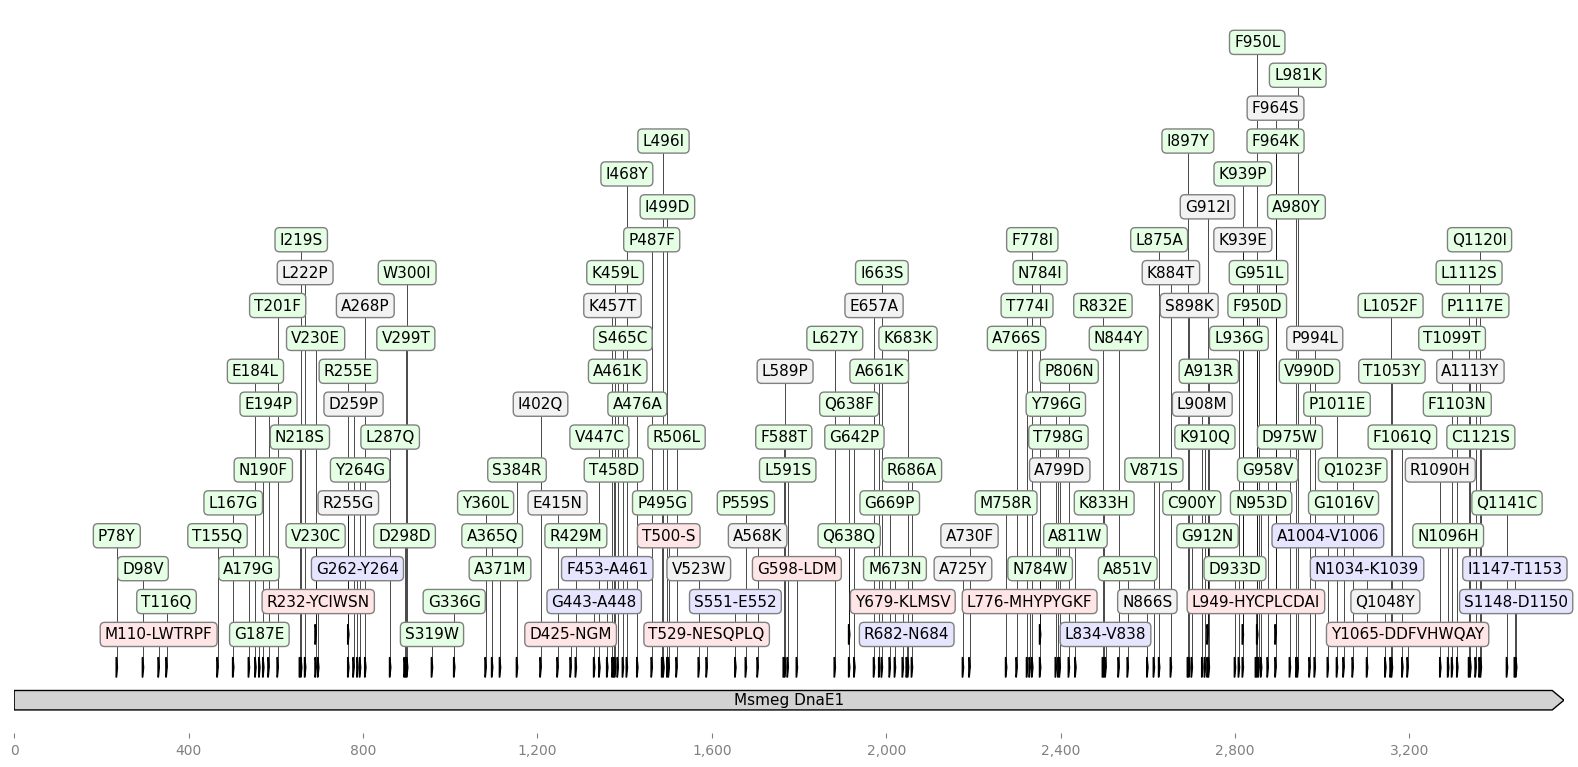

In [143]:
# First, lets take a look at the mutations that we have selected


# Plot and save the legend

legend = eBlocks_instance.plot_legend(show=True)
legend.savefig(output_location + gene_name + '_legend.png', dpi=100)


# TODO Maybe change colors of every double mutant, to see if they are in the same region to distinguish between them

record = eBlocks_instance.plot_eblocks_mutations(idx_dna_tups=None, eblocks=False, mutations=True, genename=eBlocks_instance.gene_name)
ax, _ = record.plot(figure_width=20)

# Save the eBlocks plot

# TODO Fix this, dt_string is not working here
ax.figure.savefig( f'{output_location}/mutations_Msmeg_DnaE1_N{total_number_mutations}.png', dpi=300)

In the above plot we can view the mutations and how they are divided over the gene. Now we let the program design the eBlock regions in such a way that as many mutations as possible are put on the same eBlock.

Optimizing based on price per bp ...
Lowest cost: 5820.05 with cluster cluster N=5
expected cost, counting 0.05 cent per bp: 5820.05 euros
Designed eBlocks and stored output in  output/


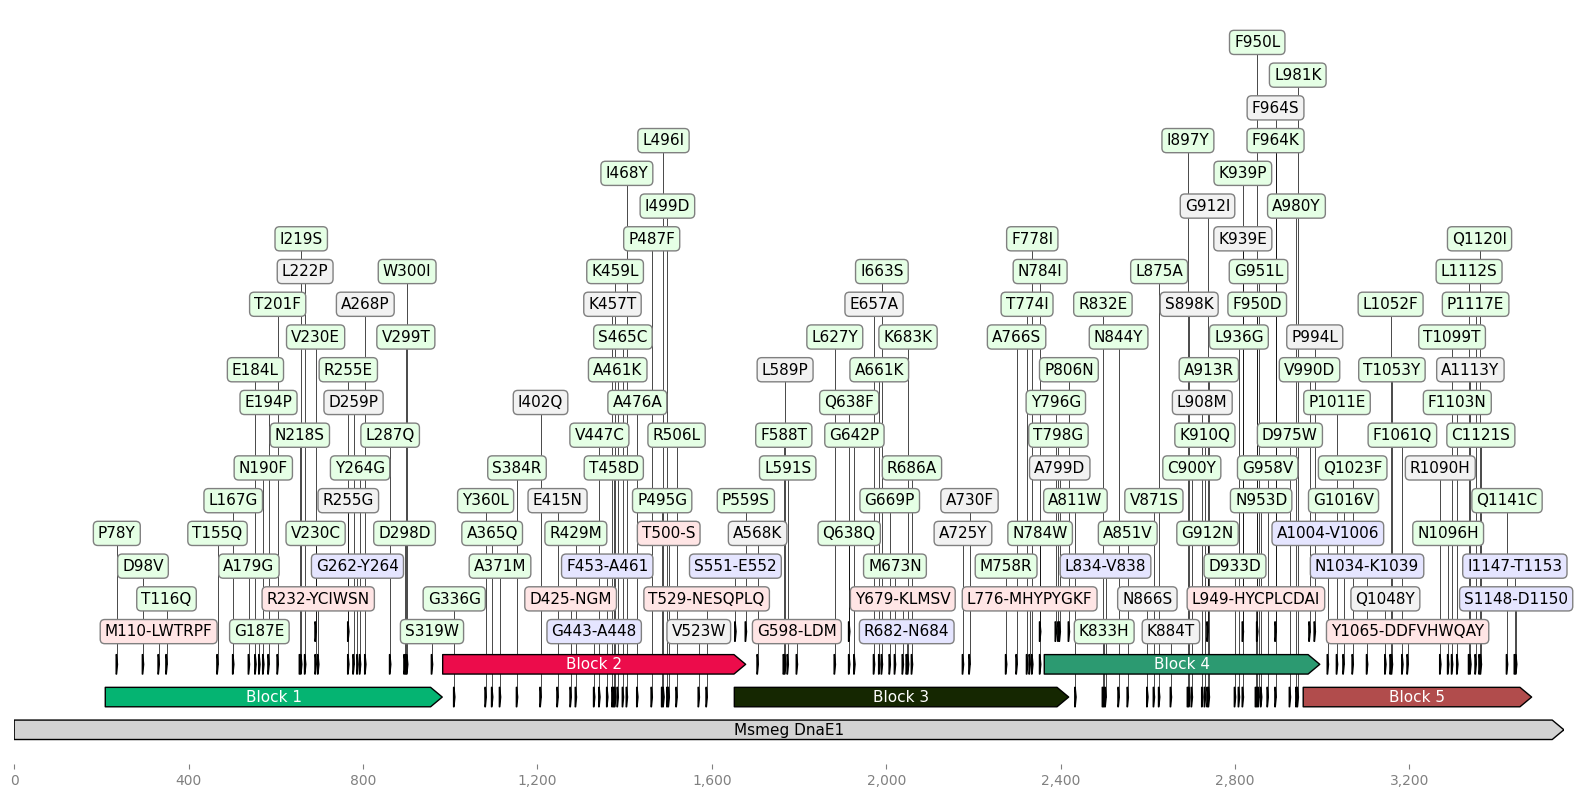

In [144]:
# Run the design of the eBlocks

# TODO Save the plots of the mutations, barplot and the DNA sequence plot in the output folder


# Original
# TODO Find a way to not show the plot of the eBlocks, but still save it

eBlocks_instance.run(show=False)

# TODOD ADD SOME EXTRA TESTS TO SEE IF THE OUTPUT IS CORRECT AND WORKING (LOT OF DOUBLE MUTATNS, SINGLE MUTATIONS INSERTIONS AND DELETIONS)
# TODO Try this tutorial with 100 or 200 mutations as well and see how this affects the plot

Optimizing based on amount of eBlocks ...
Fewest blocks: 3 with cluster cluster N=5
expected cost, counting 0.05 cent per bp: 9640.4 euros
Designed eBlocks and stored output in  output/


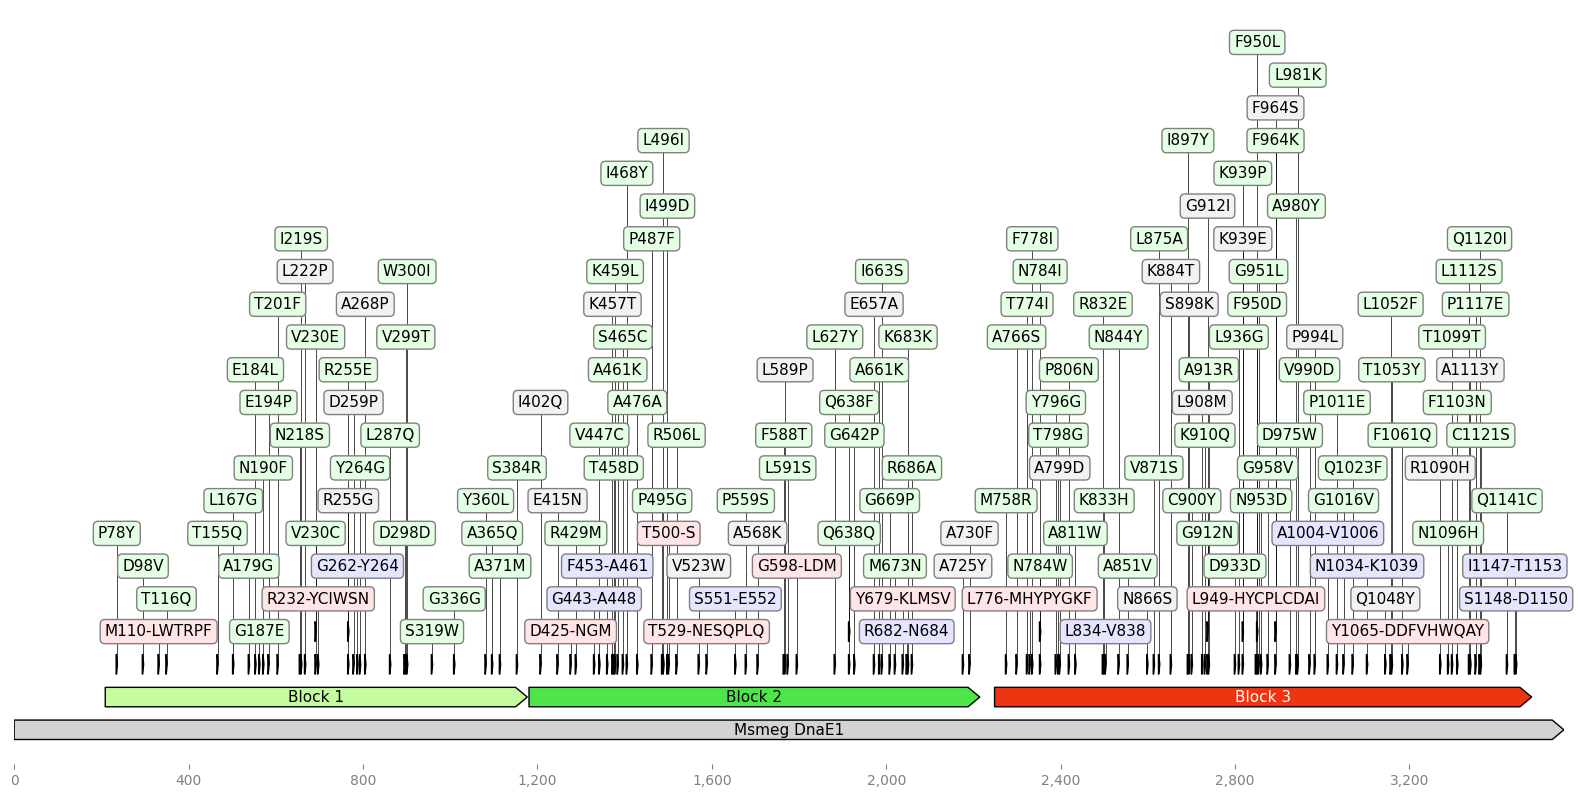

In [145]:
# Now lets do the same but optimize the amount of eBlocks instead of the cost

optimize = 'amount'

eBlocks_instance = DesignEblocks(
                        sequence_fp=msmeg_dnae1,
                        gene_name=gene_name,
                        mutations_fp=mutationsfile,
                        optimize=optimize, # Optimize for the cost of the eBlocks (default) 'cost', or for the number of eBlocks 'amount'
                        output_fp=output_location,
                        species=codon_usage,
                        codon_usage_fp=codon_usage_fp)

eBlocks_instance.run()

In this plot you can see .. how many mutants you can make with an eBlock

In [ ]:
# DESCIBE WHAT OTHER FILES ARE CREATED



In [ ]:
# DECRIBE THE NEXT STEPS

In [ ]:
# Next; design IVA primers to open up destination plasmid

mut_gene_blocks_fp = os.path.join(output_location, "mut_gene_blocks.npy")
wt_gene_blocks_fp = os.path.join(output_location, "wt_gene_blocks.npy")

# Create class instance

design_primers = DesignPrimers(wt_gene_blocks_fp=wt_gene_blocks_fp, 
                               mut_gene_blocks_fp=mut_gene_blocks_fp, 
                               output_location=output_location,
                               input_gene_path=gene,
                               snapgene_file=vector)

# Design the primers

design_primers.run()

# Also write results to files that SnapGene can open
primers_fp = os.path.join(output_location, "IVA_primers.csv")
gene_blocks_mutation_info_fp = os.path.join(output_location, "gene_blocks.txt")

# If you have SnapGene installed, you can add the mutations as features in this file

snapgene_output = SnapGeneOutput(wt_gene_blocks_fp = wt_gene_blocks_fp,
                                 mut_gene_blocks_fp = mut_gene_blocks_fp,
                                 primers_fp = primers_fp,
                                 output_location = output_location,
                                 snapgene_file = vector,
                                 gene_blocks_info_fp = gene_blocks_mutation_info_fp)
snapgene_output.run()


In [ ]:
# TODO CLEANUP AND REMOVE UNNECCESSARY FILES